# Progetto Machine Learning - Wine Dataset

In [7]:
# load libraries
import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

In [8]:
# load dataset
wine = load_wine()

# create data and target 
X, y = wine.data, wine.target

print(X.shape, y.shape)

(178, 13) (178,)


In [9]:
# print dataset information
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

+ This dataset has a sample size of 178
+ There are 13 continuous numerical features containing information about the chemical profile of the wine 
+ There are three classes of wine, labelled from 0 to 2

We are going to use the Random Forest Classifier as the model, which does not require feature scaling. First, we randomly split the dataset into training and test sets.

In [10]:
# split into train and test dataset
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, 
                                                test_size=0.4, 
                                                random_state=42, 
                                                stratify=y) # equal proportion of classes between two sets 

In [11]:
# create model
rf = RandomForestClassifier(oob_score=True, random_state=42)

# show current parameters
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In Random Forest, the main parameters to validate are max_features, which determines the number of features to consider when looking for the best split, and n_estimators, which determines the number of trees in the forest.

We will cross-validate these parameters along with the depth of the trees and the criterion for calculating impurity.

In [12]:
# grid of parameter values to validate
p_grid = [{'max_features': ['auto', 'log2'],
           'n_estimators': [25, 50, 75, 100],
           'max_depth' : [None, 4, 6, 8],
           'criterion' : ['gini', 'entropy']}]

# set up GridSearch
optimal_params = GridSearchCV(rf, # estimator
                              param_grid=p_grid, # parameters
                              cv=5,
                              scoring='accuracy')

# train
optimal_params.fit(Xtrain, ytrain)

# get best parameters and score
print(optimal_params.best_params_)
print(optimal_params.best_score_)

{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 50}
0.9904761904761905


The Out-of-Bag score is an estimate of generalization capacity and a measure of the goodness of the model, calculated using Out-of-Bag samples.

In [13]:
# get validated model
rf_val = optimal_params.best_estimator_

# get out of bag score
rf_val.oob_score_

0.9811320754716981

Now that we have validated the model, we can train it, obtain predictions for the test set and compare predictions with true labels to evaluate its performance.

In [14]:
# train model
rf_val.fit(Xtrain, ytrain)

# get predictions
ypred = rf_val.predict(Xtest)

# evaluate performance
print(metrics.classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       1.00      0.97      0.98        29
           2       1.00      1.00      1.00        19

    accuracy                           0.99        72
   macro avg       0.99      0.99      0.99        72
weighted avg       0.99      0.99      0.99        72



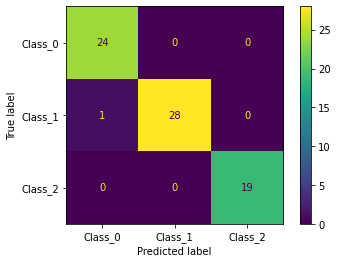

In [15]:
# create a confusion matrix
ConfusionMatrixDisplay.from_estimator(rf_val, 
                                      Xtest,
                                      ytest,
                                      display_labels=['Class_0', 'Class_1', 'Class_2'])

We can see from the confusion matrix that only one sample belonging to class_1 was mislabelled as class_0. This shows in the classification report, as the only class with perfect precision and recall is class_2, whereas precision for class_0 is less than 1 (there was one false positive) and recall for class_1 is less than 1 (there was one false negative). The F1 score is the harmonic mean of the precision and recall.

With Random Forest, we can also evaluate feature importance, which is calculated based on the impurity reduction of each feature and indicates the most important features for classification. 

In [16]:
impo = np.round(rf_val.feature_importances_.reshape((13, 1)) * 100, decimals=2)

for i in np.hstack((np.array(wine.feature_names).reshape((13, 1)), impo)):
    print('{}: {}%'.format(i[0], i[1]))

alcohol: 15.9%
malic_acid: 2.68%
ash: 2.55%
alcalinity_of_ash: 2.16%
magnesium: 5.78%
total_phenols: 1.84%
flavanoids: 16.25%
nonflavanoid_phenols: 1.14%
proanthocyanins: 3.42%
color_intensity: 15.32%
hue: 9.97%
od280/od315_of_diluted_wines: 7.73%
proline: 15.24%


In this case, the most important features for classification were flavanoids, followed by alcohol, color intensity and proline.